<a href="https://colab.research.google.com/github/carolflyjs/cs230/blob/master/Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%run "/content/drive/My Drive/Colab Notebooks/Data_Processing_v2.ipynb"
%run "/content/drive/My Drive/Colab Notebooks/utils.ipynb"

     |████████████████████████████████| 1.9MB 3.4MB/s 


Using TensorFlow backend.


load_file(path, delimiter=","): return df
data_prep(df, x_columns, y_columns): return X_train, Y_train
removeSpellingErrors(df): return new_df
tokenize_and_pad(X_train), return X_train_padded, max_value, vocab_size, tokenizer
store_weights(mode, model_name, path="/content/drive/My Drive/cs230/")
load_weights(mode, model_name, path="/content/drive/My Drive/cs230/")
join_histories_and_plot(*histories)

load_embedding_matrix(embeddings_index, vocab_size, embedding_dim, word_index)
embedding_index = pre-trained embedding dictionary with key being the word and value being the embedding scores
vocab_size = total number of unique tokens in the training data
embedding_dim = dimension used in the embedding_index for each token
word_index = token dictionary with key being the word and value being the token



### Build a base model with one hidden layer

1.   L1 is an embedding layer to embed all words. It is then flattened.
2.   L2 is the softmax output.

Use standard cross entropy loss function.




In [0]:
def build_naive_embedding_model(embedding_dim = 10, optimizer="adam"): 
    X_input = Input(shape=(max_value * 2,), dtype="int32")
    X = Embedding(vocab_size, embedding_dim)(X_input)
    X = keras.layers.Flatten("channels_last")(X)
    X = Dense(5, activation="softmax")(X)
    # X = Dense(5, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.001))(X)

    model = Model(inputs=[X_input], outputs=X)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    model.summary()

    return model

0.03
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 16, 10)            35170     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 805       
Total params: 35,975
Trainable params: 35,975
Non-trainable params: 0
_________________________________________________________________
Train on 290693 samples, validate on 18723 samples
Epoch 1/50
290693/290693 [==============================] - 13s 44us/step - loss: 1.3491 - categorical_accuracy: 0.7550 - val_loss: 0.5807 - val_categorical_accuracy: 0.7825
Epoch 2/50
290693/29069

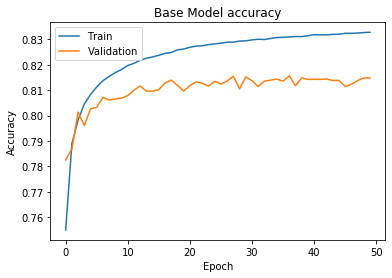

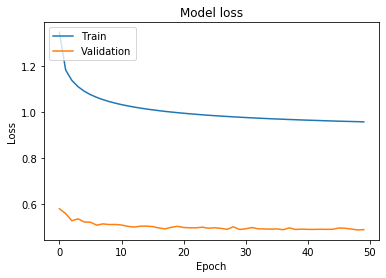

In [16]:
learning_rate = 0.03
print(learning_rate)
optimizer = keras.optimizers.Adagrad(lr=learning_rate)

base_model = build_naive_embedding_model(optimizer=optimizer)
history = base_model.fit(x=X_train_tokenized, y=Y_train, batch_size=32, epochs=50, validation_data=(X_dev_tokenized, Y_dev), class_weight=class_weight)
combined = join_histories_and_plot("Base Model", history)

In [17]:
getConfusionMatrix(base_model, X_test_tokenized, Y_test)

[[ 873   12   16   14   38]
 [   6 1011   16   17   32]
 [   6    1  151    8   40]
 [   3    8    6  155   33]
 [  37   48  107  114  354]]


In [18]:
base_model.evaluate(x=X_test_tokenized, y=Y_test)

3106/3106 [==============================] - 0s 19us/step


[0.49148379148242555, 0.8190598840952994]

In [0]:
errorAnalysis(base_model, X_test_tokenized, Y_test)